In [ ]:
# This takes amplitudes of fake companions empirically found to be 5-sigma above the noise,
# and calculates a correction term by which the input 5-sigma curve has to be multiplied.

# Created 2020 Mar 19 by E.S.

In [ ]:
# INPUT: list of 
# 1.) Angular distance from host star (asec)
# 2.) Linearly-scaled contrast (i.e., ratio of amplitudes between a fake planet and the host star;
#       0.01 means '0.01 of host star amplitude'). These contrasts are those at which a fake planet
#       has an amplitude such that the signal-to-noise is 5

# OUTPUT: list of
# 1.) Angular distance from host star (asec)
# 2.) Multiplicative factor

In [ ]:
# Ref: Research journal, 2020 Mar 21

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

import matplotlib.pyplot as plt

In [32]:
original_contrast_curve = pd.read_csv("data/fake_contrast_curve.csv")

In [11]:
# Set some initial constants

# Note that radii are all in units of FWHM unless explicity
# stated otherwise

#### $N_{FP}^{(tot)}=0.01$
#### $R_{max}=20$

In [4]:
N_FP_tot = 0.01
R_max = 20

In [5]:
# Then at each radius we have a constant number of false positives

#### $N_{FP}=N_{FP}^{(tot)}/R_{max}$

In [6]:
N_FP = np.divide(N_FP_tot,R_max)

In [7]:
# And thus the FPF is a function of radius:

#### $FPF(r)=\frac{N_{FP}}{2\pi r}$

In [8]:
def FPF_r(r):
    
    return np.divide(N_FP,2*np.pi*r)

In [9]:
# Under the hypothesis H0, the FPF(r) is

#### $FPF(r)=\int_{\tau}^{\infty}p_{t}(x,n_{2}-1)dx |_{r}$

In [10]:
# This means that tau is where the CDF is 1-FPF (DOFs implied):

#### $CDF(\tau)=1-FPF(r)$

In [18]:
# To find tau, invert the CDF:

#### $\frac{\tau(r)}{\bar{s}(r)}=C_{st}^{-1}(1-FPF(r)|n-1)$

In [30]:
# Example CDF inversion:

# generate a t-distribution with 10 DOFs
df = 10
mean, var, skew, kurt = t.stats(df, moments='mvsk')

# print the tau/s-bar where the FPF=0.5 (should be zero!)
print("PPF where FPF=0.5:")
print(t.ppf(0.5, df))

# print the tau/s-bar where the FPF=0.1 (should be negative!)
# and check it with the cdf
print("PPF where FPF=0.1:")
tau_0pt1 = t.ppf(0.1, df)
print(tau_0pt1)
print("Check with CDF:")
print(t.cdf(tau_0pt1, df))

PPF where FPF=0.5:
6.80574793290978e-17
PPF where FPF=0.1:
-1.3721836411102861
Check with CDF:
0.10000000000000742


In [ ]:
# Now, under the hypothesis H1, consider a fixed TPF.

#### $TPF(r) = \int_{\mu_{c}-\tau}^{\infty}p_{t}(x,n_{2}-1)dx |_{r}$

In [ ]:
# Inverting, rearranging, and substituting in the expression for the inverted CDF, we have

#### $\frac{\mu_{c}(r)}{\bar{s}(r)} = C_{st}^{-1}(1-FPF(r)|n-1) + C_{st}^{-1}(TPF|n-1)$

In [ ]:
# The fake injected planets are of amplitude N*sbar,
# so just divide those amplitudes by N (which is probably 5).

# The contrast level 'corrected' for small angles is then 

#### $\mu_{c}(r) = \bar{s}(r)\left[C_{st}^{-1}(1-FPF(r)|n-1) + C_{st}^{-1}(TPF|n-1)\right]$

In [ ]:
# Make a function out of this:

In [36]:
def mu_c_5sig(n_pass,sbar_pass,r_pass,TPF_pass):
    '''
    INPUTS:
    n_pass: number of points (DOF = n_pass - 1)
    sbar_pass: the empirical fake planet amplitude equivalent to '1-sigma' (note the '1')
    r_pass: the radius in FWHM units (which is used to calculate FPF(r))
    TPF_pass: the fixed true positive fraction
    
    OUTPUTS:
    correction_factor: the factor by which to multiply the input 1-sigma contrast curve
    corrected_curve: the actual corrected '5-sigma' curve, found by using the correction factor
    '''
    
    # generate a t-distribution with DOF=n-1
    df = n_pass-1
    mean, var, skew, kurt = t.stats(df, moments='mvsk')
    
    # calculate the FPF
    FPF_this_r = FPF_r(r_pass)
    
    # calculate the first and second Cst^-1 terms in the square brackets
    ppf_1st = t.ppf(1-FPF_this_r, df)
    ppf_2nd = t.ppf(TPF_pass, df)
    
    # find the correction factor
    corrxn_factor = (ppf_1st+ppf_2nd)
    
    # and multiply everything with 5*s-bar to get a corrected '5-sigma' curve
    mu_c_r_5sig = 5.*np.multiply(sbar_pass,corrxn_factor)
    
    # initialize a dataframe
    dict_corrxn = {"rad_asec": r_pass, 
                   "corrxn_factor": corrxn_factor, 
                   "original_contrast_lim": original_contrast_curve["contrast_lim"],
                   "mu_c_r_5sig": mu_c_r_5sig}
    df_corrxn = pd.DataFrame(dict_corrxn)
    
    return df_corrxn

In [37]:
# test with some plots

In [38]:
test_df = mu_c_5sig(n_pass=10,
                    sbar_pass=original_contrast_curve["contrast_lim"],
                    r_pass=original_contrast_curve["asec"],
                    TPF_pass=0.95)

In [39]:
original_contrast_curve

,asec,contrast_lim
0,0.2,0.01000
1,0.4,0.00800
2,0.6,0.00400
3,0.8,0.00350
4,1.0,0.00090
5,1.2,0.00020
6,1.4,0.00018
7,1.6,0.00016
8,1.8,0.00014


In [40]:
test_df

,rad_asec,corrxn_factor,original_contrast_lim,mu_c_r_5sig
0,0.2,6.779005,0.01000,0.338950
1,0.4,7.298009,0.00800,0.291920
2,0.6,7.615535,0.00400,0.152311
3,0.8,7.847569,0.00350,0.137332
4,1.0,8.031599,0.00090,0.036142
5,1.2,8.184685,0.00020,0.008185
6,1.4,8.316083,0.00018,0.007484
7,1.6,8.431395,0.00016,0.006745
8,1.8,8.534279,0.00014,0.005974


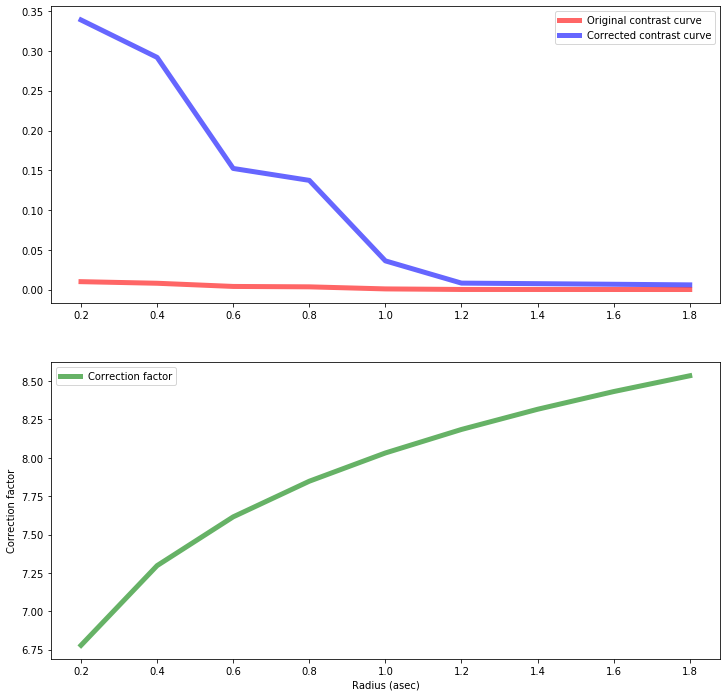

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12))

ax[0].plot(test_df["rad_asec"], test_df["original_contrast_lim"],'r-', lw=5, alpha=0.6, label="Original contrast curve")
ax[0].plot(test_df["rad_asec"], test_df["mu_c_r_5sig"],'b-', lw=5, alpha=0.6, label="Corrected contrast curve")
ax[1].set_ylabel("Contrast curves")
ax[0].legend()

ax[1].plot(test_df["rad_asec"], test_df["corrxn_factor"],'g-', lw=5, alpha=0.6, label="Correction factor")
ax[1].set_ylabel("Correction factor")
ax[1].set_xlabel("Radius (asec)")
ax[1].legend()